# Image Classification with Convolutional Neural Networks in Keras
## Computer Vision and Image Processing - Lab Session 6
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it - Alex Costanzino, alex.costanzino@unibo.it

Write smt abt CNN and image classification.

## The image classification task
Image classification is the task of assigning a class label to an entire image.
In its simplest form images are expected to include no more than one class.


<img src="LabSession6Images/image_classification.png" width="768">

Image classification models take an image as input and return a prediction about which class the image belongs to.

## *Keras* and *Tensorflow*
[TensorFlow](https://www.tensorflow.org/) is a machine learning framework employed to design, build, and train deep learning models. 
[Keras](https://keras.io/) is a simple API - built on top of TensorFlow - developed for fast experimentation.

Together they provide to the user intuitive interfaces for:
* **Layers** (i.e. linear layer, convolutional layer);
* **Activation functions** (i.e. sigmoid, ReLU, softmax);
* **Loss functions** (i.e. cross-entropy, KL divergence);
* **Regularizers**;
* **Metrics** (i.e. accuracy, recall);
* **Optimizers** (i.e. SGD, RMSprop);
* **Models**;
* **Datasets**;

... and much more.

For further details refer to the [official documentation](https://keras.io/api/).

## Implementing an **Image Classifier** with Keras

A very *high-level pipeline* for experimenting with machine learning models is devised as follows:
1. **Setup**;
2. **Data preparation**, in which the data are managed, loaded, pre-processed - if necessary - and usually inspected for debugging purposes;
3. **Model building**, in which the model is built layer-by-layer thanks to the high-level interfaces provided by Keras;
4. **Model training**, in which loss functions, metrics and optimizers are embedded to the model and the model is optimized;
5. **Model evaluation**, in which the trained model is applied to the test data to infer the new labels and to assessthem.

### 1. Setup

We import the usual libraries along with TensorFlow and fix the random seeds to a known value in order to make the experiments repeatable and check if everything it is correct.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Fixed random seed for repeatability.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### 2. Dataset preparation

#### Datasets and dataloaders
The `tf.keras.datasets` module provides some ready-to-use toy datasets for several different machine learning task. 
Such datasets are already-vectorized in Numpy format and they are usually employed for debugging or creating simple models.

However, Keras is also endowed with data loading utilities, located in `tf.keras.utils`, which help you go from raw data on disk to a `tf.data.Dataset` object that can be used to efficiently train a model.

These loading utilites can be combined with preprocessing layers to futher transform your input dataset before training (i.e. data augmentation).

##### Fashion-MNIST
**Fashion-MNIST** is a dataset of Zalando's article images, consisting of a training set of 60k samples and a test set of 10k samples. Each sample is a 28x28 grayscale image, associated with a label from 10 different mutually exclusive classes.

<img src="LabSession6Images/fashion-mnist.png" width="512">

#### Data loading
To retrieve the dataset it suffices to import the dataset and call the `load_data()` method on it.
The method will download, unzip and process the dataset in order to obtain a tuple for the training data and a tuple for the test data.

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data();

#### Data inspection
There are several things that we can inspect in order to ensure that everything it is fine.

For instance we can start by checking whether the expected number of samples and size of the images are correct:

In [3]:
n_train, w_train, h_train = x_train.shape
n_test, w_test, h_test = x_test.shape

unique_labels = np.unique(y_train)
n_classes = len(unique_labels) # N.B. np.unique(x) returns the list of unique values inside the array x.

print(f"There are {n_train} samples in the training set, with size ({w_train},{h_train}).")
print(f"There are {n_test} samples in the test set with, size ({w_test},{h_test}).")
print(f"There are {n_classes} different classes.")
print(f"The unique labels are {unique_labels}.")

There are 60000 samples in the training set, with size (28,28).
There are 10000 samples in the test set with, size (28,28).
There are 10 different classes.
The unique labels are [0 1 2 3 4 5 6 7 8 9].


Note that checking the number of classes by checking the number of unique values in the training set we are hypothesizing that the class distribution of the input data it is the same of the output data, i.e. every class in the test set is also in the training set.

Let us then extract a random index to visually inspect some images of the training set:

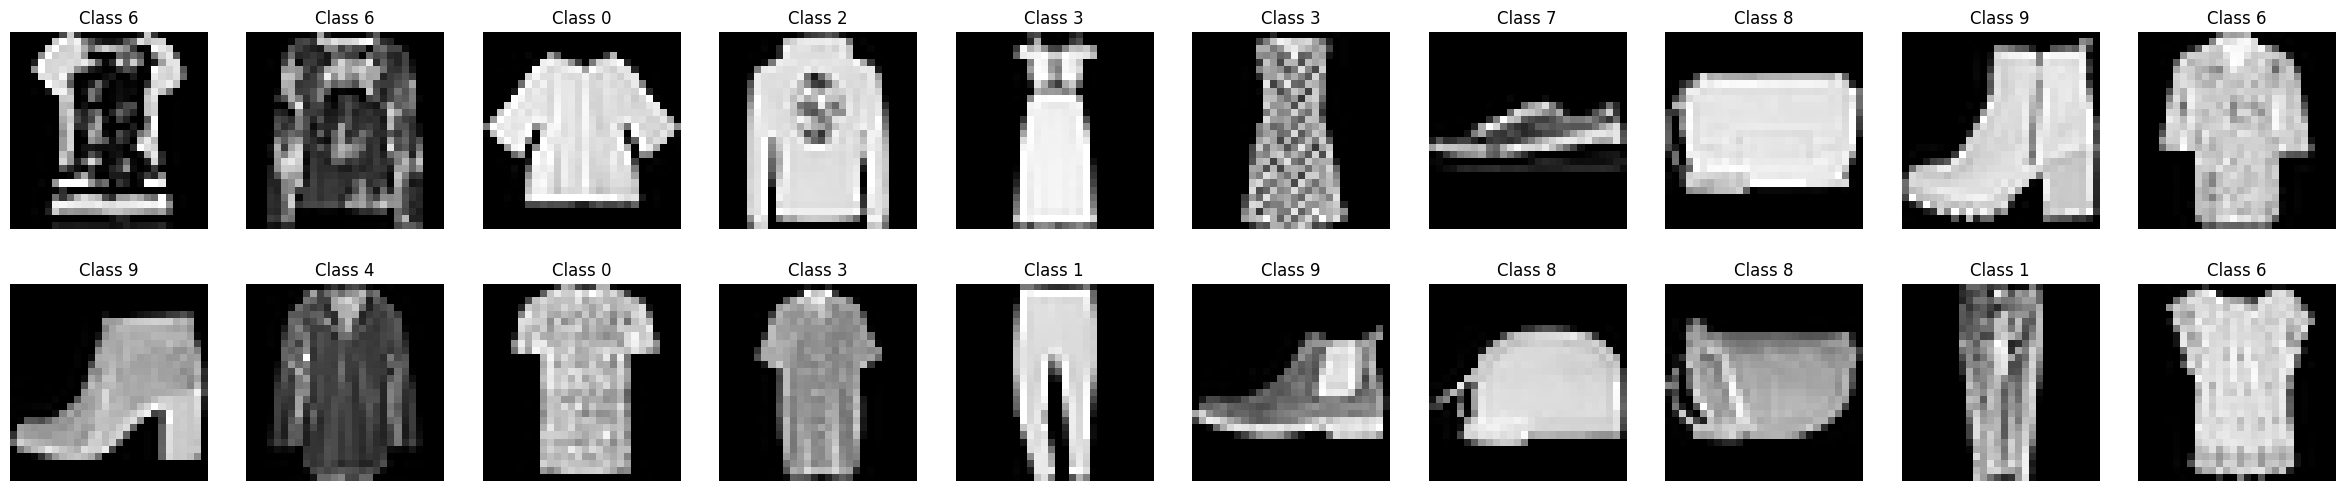

In [4]:
rand_idx = np.random.randint(0, x_train.shape[0])

fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()

for i in range(20):
    rand_idx = np.random.randint(0, x_train.shape[0])

    ax[i].set_axis_off()
    
    ax[i].set_title(f"Class {y_train[rand_idx]}")
    ax[i].imshow(x_train[rand_idx], vmin = x_train[rand_idx].min(), vmax = x_train[rand_idx].max(), cmap = "gray")

Then, we can check the range of these images:

In [5]:
print(f"The images are in the range [{x_train.min()},{x_train.max()}].")

The images are in the range [0,255].


Of course we know that these images are all in the range $[0,255]$.

#### Data normalization
In general it is a good practice to normalize the input data of a machine learning model (for certain kind of model it can be also mandatory) for two main reasons:
1. After normalization all data lies in the same interval and so metric and losses based on similarities make sense;
2. Smaller data begets smaller weights and hence a more efficient learning.

In this case a simple rescaling in the $[0,1]$ range it suffices:

In [6]:
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

print(f"The new range of the images is [{x_train.min()},{x_train.max()}].")

The new range of the images is [0.0,1.0].


Then, since these images are grayscale we need to add a dimension that takes into account the dimensionality of the channel:

In [7]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"The new shape of the feature matrix is: {x_train.shape}.")

The new shape of the feature matrix is: (60000, 28, 28, 1).


In case of RGB images this is not necessary since they already have 3 channels.

### 3. Model building

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [9]:
input_shape = x_train.shape[1:]
print(f"The input shape of the CNN is {input_shape}.")

The input shape of the CNN is (28, 28, 1).


In [18]:
model = Sequential(
    [
        Input(shape = input_shape),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
        Dropout(rate = 0.15),
        Dense(units = n_classes, activation = "softmax"),
    ]
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1600)             

### 4. Model training

In [19]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = SGD(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()

In [20]:
batch_size = 128
epochs = 20
val_split_percentage = 0.3

model.compile(loss = loss_fcn, 
              optimizer = opt, 
              metrics = ["accuracy"])

model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = val_split_percentage);

Epoch 1/20
329/329 [==============================] - 6s 17ms/step - loss: 2.2831 - accuracy: 0.1657 - val_loss: 2.2573 - val_accuracy: 0.2714
Epoch 2/20
329/329 [==============================] - 6s 18ms/step - loss: 2.2325 - accuracy: 0.3060 - val_loss: 2.2015 - val_accuracy: 0.4354
Epoch 3/20
329/329 [==============================] - 6s 18ms/step - loss: 2.1656 - accuracy: 0.3789 - val_loss: 2.1136 - val_accuracy: 0.4729
Epoch 4/20
329/329 [==============================] - 6s 18ms/step - loss: 2.0482 - accuracy: 0.4348 - val_loss: 1.9517 - val_accuracy: 0.5010
Epoch 5/20
329/329 [==============================] - 6s 17ms/step - loss: 1.8358 - accuracy: 0.4869 - val_loss: 1.6703 - val_accuracy: 0.5663
Epoch 6/20
329/329 [==============================] - 5s 17ms/step - loss: 1.5422 - accuracy: 0.5214 - val_loss: 1.3605 - val_accuracy: 0.5996
Epoch 7/20
329/329 [==============================] - 5s 17ms/step - loss: 1.3016 - accuracy: 0.5565 - val_loss: 1.1630 - val_accuracy: 0.6283

### 5. Model evaluation

We can also visualize the model accuracy and loss for the training and the validation sets. 
Since the validation set is class-balanced, accuracy provides an unbiased representation of the model's performance.

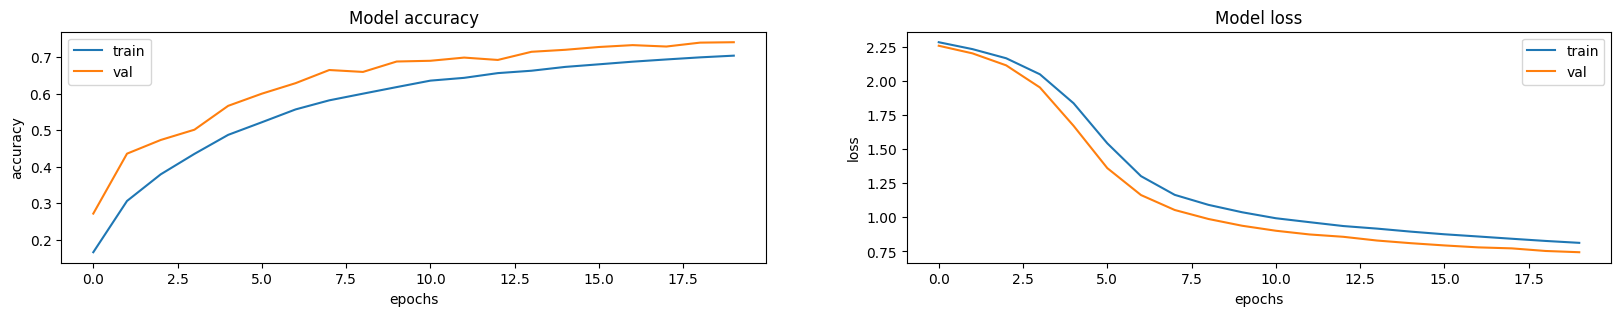

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [22]:
test_loss, test_metric = model.evaluate(x_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

313/313 [==============================] - 1s 3ms/step - loss: 0.7680 - accuracy: 0.7319
The test loss is 0.7680, the test accuracy is 0.7319.
